<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Projeto_final/Exploratoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### Importação das bibliotecas e definição de funções

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import math

In [2]:
# Função que remove pacientes internados na UTI nas duas primeiras horas
def remove_pts(data):
  remove = data.query("WINDOW == '0-2' and ICU == 1")["PATIENT_VISIT_IDENTIFIER"].values
  out = data.query("PATIENT_VISIT_IDENTIFIER not in @remove")
  return(out)

In [3]:
# Função que preenche as tabelas com backfill e forwardfilll quando necessário, utilizando apenas dados dos pacientes antes de irem para UTI
def fill_table(data):
    def fill_rows(rows):
        rows.loc[rows["ICU"] != 1] = rows.loc[rows["ICU"] != 1].fillna(method='bfill').fillna(method='ffill')
        # garante que só vai preencher as linhas em que o paciente ainda não foi pra UTI
        return rows
    
    cont_columns = data.iloc[:, 13:-2].columns # identificando o numero correto das colunas com dados que iremos preencher
    cont_features = data.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[list(cont_columns) + ["ICU"]].apply(fill_rows)
    cont_features.drop("ICU", axis=1, inplace=True)
    
    cat_features = data.iloc[:, :13]
    out = data.iloc[:, -2:]
    
    final_data = pd.concat([cat_features, cont_features, out], ignore_index=True, axis=1)
    final_data.columns = data.columns
    
    return final_data

In [4]:
# Função que identifica quais pacientes foram para UTI e simplifica o output colocando-os em primeiro
def id_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

In [5]:
# Função que plota gráficos de análise de variáveis categóricas
def categorical_plot(data, x, xtitle, figsize = (8, 6), rotation = None):

  plt.figure(figsize = figsize)
  plt.title("Análise categórica", fontsize = 20)
  sns.barplot(data = data, x = x, y = data.index,
              estimator = len, ci = None, hue = "ICU",
              order = data.loc[:, x].sort_values().unique())
  plt.tick_params(axis = "both", which = "major", labelsize = 18)
  plt.ylabel("Contagem", fontsize = 16)
  plt.xticks(rotation = rotation)
  plt.xlabel(xtitle, fontsize = 18)
  plt.legend(fontsize = "x-large", labels = ["Não foi para UTI", "Foi para UTI"])
  plt.show()

In [6]:
def plot_disease_group(data, xtitle, figsize = (8, 6), rotation = None):

  plt.figure(figsize = figsize)
  plt.title("Análise categórica", fontsize = 20)
  bar1 = sns.barplot(data = data.iloc[:, 4:10].melt().rename(columns = str.title),
            x = "Variable", y = "Value", 
            ci = None, color = "#1f77b4", edgecolor = "black", estimator = sum)
  bar2 = sns.barplot(data = data.query("ICU == 1").iloc[:,4:10].melt().rename(columns = str.title),
            x = "Variable", y = "Value", 
            ci = None, color = "darkorange", edgecolor = "black", estimator = sum)
  plt.tick_params(axis = "both", which = "major", labelsize = 14)
  plt.xticks(rotation = rotation)
  plt.xlabel(xtitle, fontsize = 18)
  plt.ylabel("Contagem", fontsize = 16)
  b1 = mpatches.Patch(color = "#1f77b4", label = "TOTAL")
  b2 = mpatches.Patch(color = "darkorange", label = "Foi para UTI")
  plt.legend(handles = [b1, b2], loc = "upper left", fontsize = "x-large")
  plt.show()

In [7]:
# Função que plota a matriz de correlação como mapa de calor
def corr_plot(m_corr, figsize = (18,12), title = None):
  plt.figure(figsize = figsize)
  plt.title(title, fontsize = 18)
  cmap = sns.diverging_palette(250, 15, s = 75, l = 40,
                               n = 20, center = "light", as_cmap = True)
  mask = np.triu(np.ones_like(m_corr, dtype = bool))
  out = sns.heatmap(m_corr, mask = mask, center = 0,
              fmt = ".2f", square = True, cmap = cmap)
  plt.show()

###### Importação dos dados

df_kg = dataframe do kaggle

In [8]:
df_kg = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")

In [9]:
df_kg.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [10]:
df_kg.iloc[:,0:13].isnull().any()

PATIENT_VISIT_IDENTIFIER    False
AGE_ABOVE65                 False
AGE_PERCENTIL               False
GENDER                      False
DISEASE GROUPING 1           True
DISEASE GROUPING 2           True
DISEASE GROUPING 3           True
DISEASE GROUPING 4           True
DISEASE GROUPING 5           True
DISEASE GROUPING 6           True
HTN                          True
IMMUNOCOMPROMISED            True
OTHER                        True
dtype: bool

In [11]:
print(df_kg.isnull().sum())
print(f"Total = {df_kg.isnull().sum().sum()}") # numero de células dados faltantes

PATIENT_VISIT_IDENTIFIER        0
AGE_ABOVE65                     0
AGE_PERCENTIL                   0
GENDER                          0
DISEASE GROUPING 1              5
                             ... 
RESPIRATORY_RATE_DIFF_REL     748
TEMPERATURE_DIFF_REL          694
OXYGEN_SATURATION_DIFF_REL    686
WINDOW                          0
ICU                             0
Length: 231, dtype: int64
Total = 223863


Antes de mais nada, o primeiro passo deve ser remover de prontidão todos os pacientes que deram entrada na UTI na primeira janela de tempo. Essa medida é baseada na recomendação do Sírio Libanês de utilizar somente os dados disponíveis **até o momento** da internação.

In [12]:
df_fill1 = remove_pts(df_kg)

Depois, faremos o preenchimento com backfill ou forwardfill, a depender da situação, mas sem utilizar os dados **após** o momento da internação. Como mencionado anteriormente, a recomendação é não utilizar esses valores, e também evitar usá-los como base para preencher os dados faltantes, pois não há como saber se as medidas associadas com a janela de internação foram realizadas logo antes, ou após o momento da internação.


In [13]:
df_fill2 = fill_table(df_fill1)

In [14]:
print(df_fill2.isnull().sum())
print(f"Total = {df_fill2.isnull().sum().sum()}") # numero de células dados faltantes

PATIENT_VISIT_IDENTIFIER        0
AGE_ABOVE65                     0
AGE_PERCENTIL                   0
GENDER                          0
DISEASE GROUPING 1              5
                             ... 
RESPIRATORY_RATE_DIFF_REL     119
TEMPERATURE_DIFF_REL          101
OXYGEN_SATURATION_DIFF_REL     99
WINDOW                          0
ICU                             0
Length: 231, dtype: int64
Total = 36459


In [15]:
np.where(df_fill2.isnull())

(array([  53,   53,   53, ..., 1728, 1728, 1728]),
 array([ 13,  14,  15, ..., 190, 191, 192]))

In [16]:
df_fill2.iloc[50:55,]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
55,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.977720,-1.0,0.037037,-0.246154,-0.415094,-0.389831,0.785714,0.684211,0.037037,-0.246154,-0.415094,-0.379310,0.785714,0.684211,0.195876,-0.0125,-0.282051,-0.285714,0.868132,0.878788,-0.282051,-0.470270,-0.537313,-0.454545,0.449275,0.684211,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
56,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.977720,-1.0,0.037037,-0.246154,-0.415094,-0.389831,0.785714,0.684211,0.037037,-0.246154,-0.415094,-0.379310,0.785714,0.684211,0.195876,-0.0125,-0.282051,-0.285714,0.868132,0.878788,-0.282051,-0.470270,-0.537313,-0.454545,0.449275,0.684211,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
57,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.977720,-1.0,0.037037,-0.246154,-0.415094,-0.389831,0.785714,0.684211,0.037037,-0.246154,-0.415094,-0.379310,0.785714,0.684211,0.195876,-0.0125,-0.282051,-0.285714,0.868132,0.878788,-0.282051,-0.470270,-0.537313,-0.454545,0.449275,0.684211,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
58,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.456790,-0.338462,-0.396226,-0.050847,0.178571,0.736842,-0.456790,-0.338462,-0.396226,-0.034483,0.178571,0.736842,-0.216495,-0.0875,-0.264957,0.071429,0.494505,0.898990,-0.623932,-0.535135,-0.522388,-0.151515,-0.043478,0.736842,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,1
59,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0

Valores faltantes aparecem na seguinte situação: se um paciente tem uma lacuna de medição exatamente na janela anterior à internação e possui dados após a internação, estes valores não serão utilizados para preencher a lacuna anterior. 

Vamos aplicar a próxima função que identifica quais pacientes deram entrada na UTI e utilizará somente os dados da primeira janela de tempo. É necessário fazer essa etapa somente depois de preencher dados faltantes, pois muitos pacientes podem ter medidas faltantes em janelas iniciais, mas ainda assim terem medidas em momentos anteriores à internação; que seriam perdidas.

In [17]:
df_fill3 = df_fill2.groupby("PATIENT_VISIT_IDENTIFIER").apply(id_window)

In [18]:
print(df_fill3.isnull().sum())
print(f"Total = {df_fill3.isnull().sum().sum()}") # numero de células dados faltantes

PATIENT_VISIT_IDENTIFIER       0
AGE_ABOVE65                    0
AGE_PERCENTIL                  0
GENDER                         0
DISEASE GROUPING 1             1
                              ..
RESPIRATORY_RATE_DIFF_REL     46
TEMPERATURE_DIFF_REL          39
OXYGEN_SATURATION_DIFF_REL    36
WINDOW                         0
ICU                            0
Length: 231, dtype: int64
Total = 4635


In [19]:
np.where(df_fill3.isnull())

(array([ 16,  16,  16, ..., 341, 341, 341]),
 array([193, 194, 195, ..., 226, 227, 228]))

In [20]:
df_fill3.iloc[16:20,:] # só para garantir que mostra como tabela

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18,90,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.993216,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,1
19,95,19,1,70th,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.923600,-0.923600,...,-0.998073,-1.0,-0.234568,0.123077,-0.811321,-0.186441,-0.107143,0.842105,-0.234568,0.123077,-0.811321,-0.172414,-0.107143,0.842105,-0.030928,0.2875,-0.641026,-0.071429,0.318681,0.939394,-0.470085,-0.210811,-0.850746,-0.272727,-0.275362,0.842105,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,1
20,100,20,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.965463,-0.965463,...,-0.994912,-1.0,-0.037037,-0.553846,-0.547170,-0.593220,-0.250000,0.842105,-0.037037,-0.553846,-0.547170,-0.586207,-0.250000,0.842105,0.134021,-0.2625,-0.401709,-0.500000,0.230769,0.939394,-0.333333,-0.686486,-0.641791,-0.636364,-0.391304,0.842105,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
21,105,21,1,70th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.769634,-0.769634,-0.769634,-0.769634,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.268293,-0.268293,-0.268293,-0.268293,-1.0,-0.764521,-0.764521,...,-0.978029,-1.0,-0.358025,-0.800000,-0.320755,-0.525424,0.357143,0.684211,-0.358025,-0.800000,-0.320755,-0.517241,0.357143,0.684211,-0.134021,-0.4625,-0.196581,-0.428571,0.604396,0.878788,-0.555556,-0.859459,-0.462687,-0.575758,0.101449,0.684211,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0


In [21]:
df_kg.query("PATIENT_VISIT_IDENTIFIER == '18'")

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
90,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.993216,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
91,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,0
92,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.399177,-0.133333,-0.295597,-0.186441,0.178571,0.807018,0.382716,-0.076923,-0.415094,-0.034483,0.178571,0.842105,0.484536,-0.0125,-0.282051,-0.357143,0.494505,0.898990,-0.008547,-0.351351,-0.253731,-0.151515,-0.043478,0.842105,-0.965217,-0.865031,-0.709924,-0.647059,-1.000000,-0.959596,-0.977316,-0.876606,-0.766327,-0.736774,-1.000000,-0.960463,4-6,1
93,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.046154,-0.358491,-0.118644,0.142857,0.894737,0.333333,-0.046154,-0.358491,-0.103448,0.142857,0.894737,0.443299,0.1500,-0.230769,0.000000,0.472527,0.959596,-0.076923,-0.329730,-0.492537,-0.212121,-0.072464,0.894737,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,1
94,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.990518,-1.0,0.220576,-0.234359,-0.100629,-0.335593,-0.055952,0.726316,0.209877,-0.276923,-0.113208,-0.448276,-0.071429,0.710526,-0.072165,-0.1625,-0.213675,-0.714286,0.054945,0.858586,0.128205,-0.189189,0.074627,0.333333,0.130435,0.789474,-0.356522,-0.533742,-0.435115,0.117647,-0.380952,-0.939394,-0.545780,-0.530096,-0.627689,0.096774,-0.379238,-0.939126,ABOVE_12,1


Por último, existem pacientes que só tem medidas após a internação, e, nesse caso, deverão ser descartados, pois não é possível identificar corretamente quando as medidas foram tomadas; se logo após, logo antes ou durante o momento da internação.

In [22]:
df_fill4 = df_fill3.dropna()

In [23]:
df_fill4

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462

In [24]:
print(df_fill4.isnull().sum())
print(f"Total = {df_fill4.isnull().sum().sum()}") # numero de células dados faltantes

PATIENT_VISIT_IDENTIFIER      0
AGE_ABOVE65                   0
AGE_PERCENTIL                 0
GENDER                        0
DISEASE GROUPING 1            0
                             ..
RESPIRATORY_RATE_DIFF_REL     0
TEMPERATURE_DIFF_REL          0
OXYGEN_SATURATION_DIFF_REL    0
WINDOW                        0
ICU                           0
Length: 231, dtype: int64
Total = 0


In [25]:
df_fill4.shape

(294, 231)

Esse é o tamanho do dataset após as limpezas iniciais, mas ainda há chão!

Agora, quero examinar analisar as distribuições das variáveis categóricas, que obviamente não mudam entre as medições; e suas relações com as internações por covid.

In [26]:
df_final = df_fill4.reset_index(drop = True)

In [27]:
df_final

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-

In [28]:
df_final.loc[:,"ICU"].value_counts()

0    189
1    105
Name: ICU, dtype: int64

# Análise exploratória de variáveis categóricas:

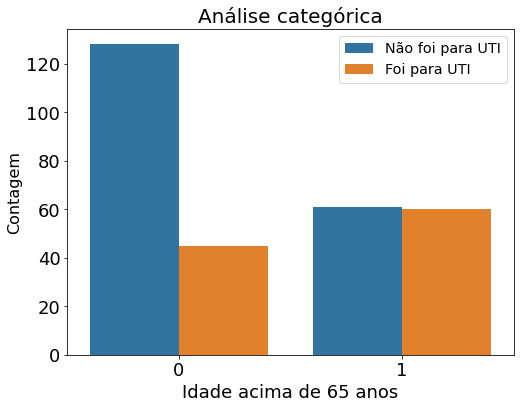

In [29]:
categorical_plot(data = df_final, x = "AGE_ABOVE65", xtitle = "Idade acima de 65 anos")

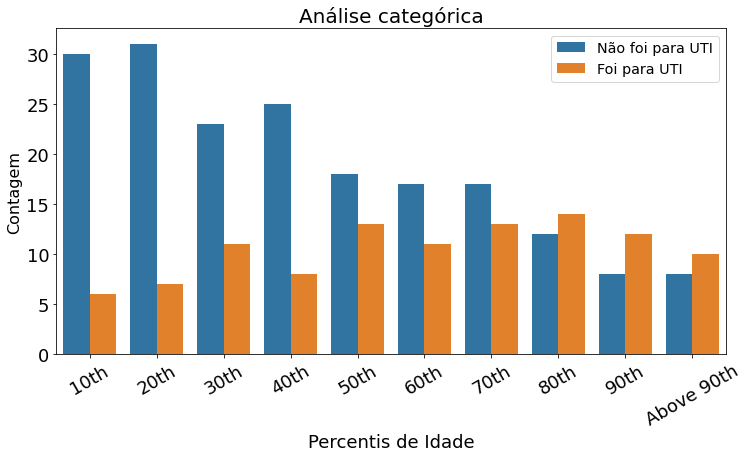

In [30]:
categorical_plot(data = df_final, x = "AGE_PERCENTIL", xtitle = "Percentis de Idade", rotation = 30, figsize = (12, 6))

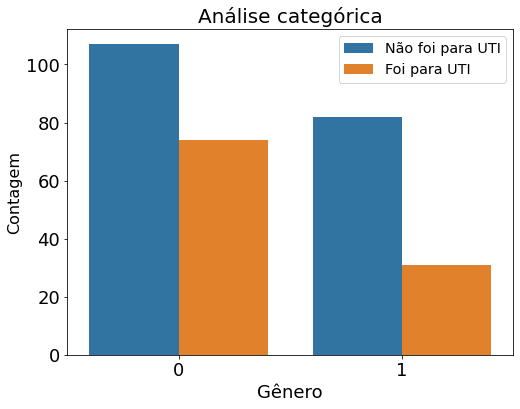

In [31]:
categorical_plot(data = df_final, x = "GENDER", xtitle = "Gênero")

0 = masculino
1 = feminino

In [32]:
df_final.loc[:,"DISEASE GROUPING 1" : "DISEASE GROUPING 6"].sum()

DISEASE GROUPING 1    28.0
DISEASE GROUPING 2     7.0
DISEASE GROUPING 3    25.0
DISEASE GROUPING 4     6.0
DISEASE GROUPING 5    34.0
DISEASE GROUPING 6    14.0
dtype: float64

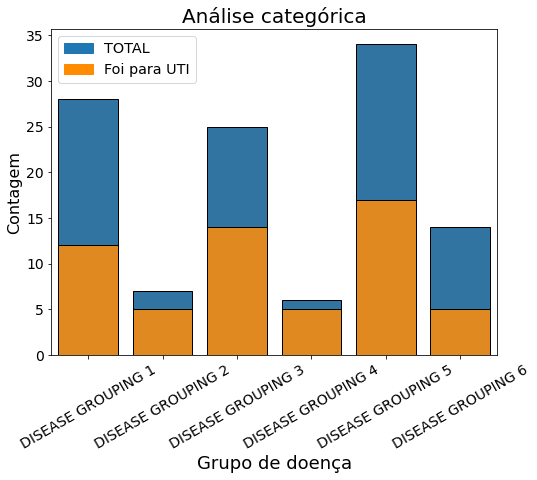

In [33]:
plot_disease_group(data = df_final, xtitle = "Grupo de doença", rotation = 30)

A visualização acaba sendo um pouco diferente, mas o princípio é o mesmo.

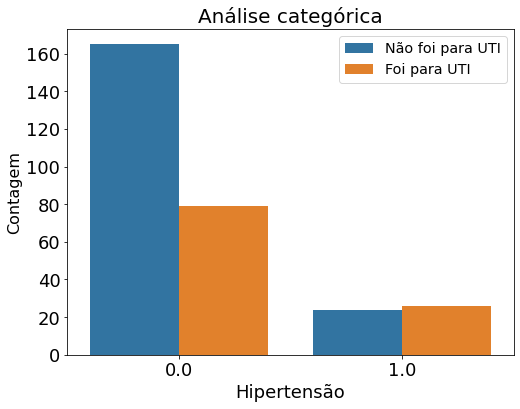

In [34]:
categorical_plot(data = df_final, x = "HTN", xtitle = "Hipertensão")

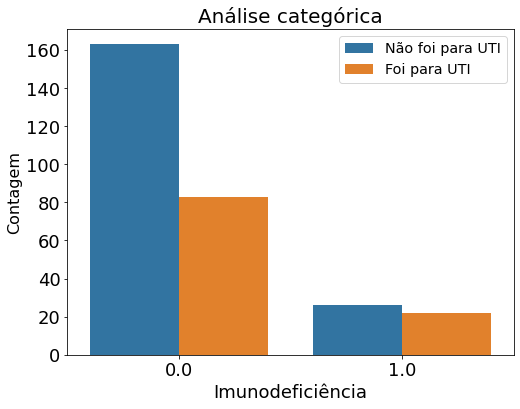

In [35]:
categorical_plot(data = df_final, x = "IMMUNOCOMPROMISED", xtitle = "Imunodeficiência")

# Análise exploratóra de variáveis contínuas

Uma última transformação necessária para melhor ajustar os dados de idade da coluna AGE PERCENTIL para a forma como serão trabalhados nos modelo de machine learning será utilizar o one-hot encoding:

In [36]:
df_final = pd.get_dummies(df_final, columns = ["AGE_PERCENTIL"])
df_final

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th
0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1,0,0,0,0,0,1,0,0,0,0
1,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1,1,0,0,0,0,0,0,0,0,0
2,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,...,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0,0,0,1,0,0,0,0,0,0
3,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,...,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0,1,0,0,0,0,0,0,0,0,0
4,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0

In [37]:
with pd.option_context('display.max_seq_items', None):
   print (df_final.columns)

Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'GENDER',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN',
       'IMMUNOCOMPROMISED', 'OTHER', 'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN',
       'ALBUMIN_MIN', 'ALBUMIN_MAX', 'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN',
       'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX',
       'BE_ARTERIAL_DIFF', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'BE_VENOUS_DIFF',
       'BIC_ARTERIAL_MEDIAN', 'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN',
       'BIC_ARTERIAL_MAX', 'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN',
       'BIC_VENOUS_MEAN', 'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX',
       'BIC_VENOUS_DIFF', 'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN',
       'BILLIRUBIN_MIN', 'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN',
       'BLAST_MEAN', 'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN',
       'CALCIUM_MEAN', 'CAL

Uma primeira abordagem é examinar o comportamento de um subgrupo de dados, por exemplo a mediana:

In [38]:
df_median = df_final.filter(regex = "_MEDIAN", axis = 1)

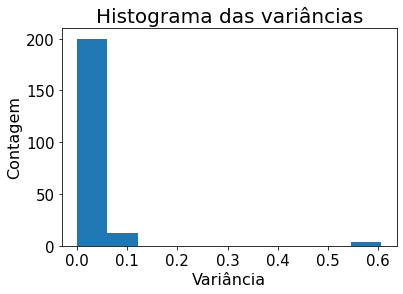

In [39]:
plt.hist(list(df_final.iloc[:,12:228].var()))
plt.title("Histograma das variâncias", fontsize = 20)
plt.xlabel("Variância", fontsize = 16)
plt.ylabel("Contagem", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 15)
plt.show()

Resumidamente, temos muitos dados com distribuições muito parecidas e muito próximas. Isso pode levar a uma grande taxa de falsos positivos devido às altas correlações entre as variáveis. A próxima etapa então é analisar diretamente estas correlações:

In [40]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Columns: 240 entries, PATIENT_VISIT_IDENTIFIER to AGE_PERCENTIL_Above 90th
dtypes: float64(225), int64(4), object(1), uint8(10)
memory usage: 531.3+ KB


É improdutivo tentar qualquer visualização de correlação de tantas colunas assim. Podemos tentar com aquele objeto das médias de novo:

In [41]:
m_corr_medians = df_median.corr().abs()

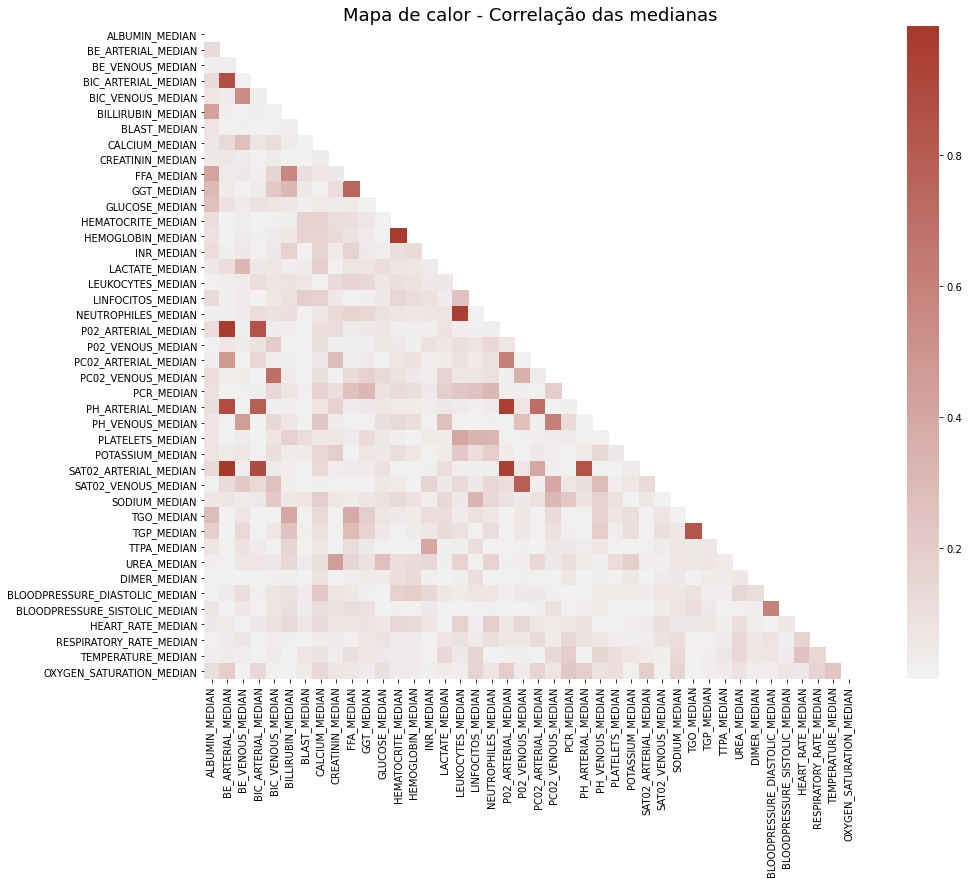

In [42]:
corr_plot(m_corr = m_corr_medians, title = "Mapa de calor - Correlação das medianas")

As medianas não apresentam altas correlações, indicando que as medidas são de fato diferentes entre si. Vamos expandir esse raciocínio para o conjunto de todas as features contínuas.

In [43]:
cont_features = df_final.iloc[:,12:228]

In [44]:
cat_features = df_final.iloc[:,np.r_[0:12, 230:239]]
out = df_final.loc[:,["WINDOW", "ICU"]]

In [45]:
m_corr = cont_features.corr().abs()
m_corr

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
ALBUMIN_MEDIAN,1.000000,1.000000,1.000000,1.000000,NaN,0.124220,0.124220,0.124220,0.124220,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MEAN,1.000000,1.000000,1.000000,1.000000,NaN,0.124220,0.124220,0.124220,0.124220,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MIN,1.000000,1.000000,1.000000,1.000000,NaN,0.124220,0.124220,0.124220,0.124220,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MAX,1.000000,1.000000,1.000000,1.000000,NaN,0.124220,0.124220,0.124220,0.124220,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625

Por que alguns valores retornam NaN?

In [46]:
cont_features.describe()

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
count,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,...,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,0.583333,0.583333,0.583333,0.583333,-1.0,-0.999127,-0.999127,-0.999127,-0.999127,-1.0,-0.966770,-0.966770,-0.966770,-0.966770,-1.0,-0.316907,-0.316907,-0.316907,-0.316907,-1.0,-0.320226,-0.320226,-0.320226,-0.320226,-1.0,-0.943813,-0.943813,-0.943813,-0.943813,-1.0,-0.992311,-0.992311,-0.992311,-0.992311,-1.0,0.329307,0.329307,0.329307,0.329307,-1.0,...,-0.960041,-0.960041,-0.960041,-1.0,-0.027803,-0.339129,-0.236224,-0.494315,0.114374,0.759233,-0.027211,-0.339770,-0.234180,-0.484635,0.112609,0.760741,0.118732,-0.103614,-0.137508,-0.412779,0.441878,0.899540,-0.310192,-0.521934,-0.381562,-0.532055,-0.075027,0.776763,-0.963561,-0.969200,-0.969777,-0.970588,-0.968902,-0.985226,-0.968574,-0.967168,-0.979110,-0.971495,-0.969322,-0.985233
std,0.121646,0.121646,0.121646,0.121646,0.0,0.012714,0.012714,0.012714,0.012714,0.0,0.098833,0.098833,0.098833,0.098833,0.0,0.006370,0.006370,0.006370,0.006370,0.0,0.081793,0.081793,0.081793,0.081793,0.0,0.047196,0.047196,0.047196,0.047196,0.0,0.117576,0.117576,0.117576,0.117576,0.0,0.080885,0.080885,0.080885,0.080885,0.0,...,0.104404,0.104404,0.104404,0.0,0.247065,0.257476,0.266177,0.190216,0.270283,0.119243,0.252430,0.258757,0.274602,0.198540,0.274601,0.125995,0.218061,0.213496,0.240673,0.199892,0.167164,0.049846,0.171095,0.183944,0.216553,0.181270,0.229508,0.122137,0.089336,0.080849,0.094492,0.090889,0.085524,0.033585,0.086117,0.087508,0.056166,0.079718,0.083745,0.034103
min,-0.578947,-0.578947,-0.578947,-0.578947,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.365854,-0.365854,-0.365854,-0.365854,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.994767,-0.994767

Os valores de "DIFF" parecem não ter nenhuma variação:

In [47]:
np.where(cont_features.describe().loc["std"] == 0)

(array([  4,   9,  14,  19,  24,  29,  34,  39,  44,  49,  54,  59,  64,
         69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129,
        134, 139, 144, 149, 154, 159, 164, 169, 174, 179]),)

Podemos removê-los:

In [48]:
remove_zero_std = cont_features.columns[np.where(cont_features.describe().loc["std"] == 0)]
remove_zero_std

Index(['ALBUMIN_DIFF', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_DIFF',
       'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_DIFF', 'BLAST_DIFF',
       'CALCIUM_DIFF', 'CREATININ_DIFF', 'FFA_DIFF', 'GGT_DIFF',
       'GLUCOSE_DIFF', 'HEMATOCRITE_DIFF', 'HEMOGLOBIN_DIFF', 'INR_DIFF',
       'LACTATE_DIFF', 'LEUKOCYTES_DIFF', 'LINFOCITOS_DIFF',
       'NEUTROPHILES_DIFF', 'P02_ARTERIAL_DIFF', 'P02_VENOUS_DIFF',
       'PC02_ARTERIAL_DIFF', 'PC02_VENOUS_DIFF', 'PCR_DIFF',
       'PH_ARTERIAL_DIFF', 'PH_VENOUS_DIFF', 'PLATELETS_DIFF',
       'POTASSIUM_DIFF', 'SAT02_ARTERIAL_DIFF', 'SAT02_VENOUS_DIFF',
       'SODIUM_DIFF', 'TGO_DIFF', 'TGP_DIFF', 'TTPA_DIFF', 'UREA_DIFF',
       'DIMER_DIFF'],
      dtype='object')

In [49]:
cont_features = cont_features.drop(remove_zero_std, axis = 1)

Mas será que foram TODOS os valores de DIFF embora?

In [50]:
cont_features.filter(regex = "_DIFF", axis = 1).columns

Index(['BLOODPRESSURE_DIASTOLIC_DIFF', 'BLOODPRESSURE_SISTOLIC_DIFF',
       'HEART_RATE_DIFF', 'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF',
       'OXYGEN_SATURATION_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF_REL',
       'BLOODPRESSURE_SISTOLIC_DIFF_REL', 'HEART_RATE_DIFF_REL',
       'RESPIRATORY_RATE_DIFF_REL', 'TEMPERATURE_DIFF_REL',
       'OXYGEN_SATURATION_DIFF_REL'],
      dtype='object')

Não, podemos continuar:

In [51]:
m_corr = cont_features.corr().abs()
m_corr

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,...,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
ALBUMIN_MEDIAN,1.000000,1.000000,1.000000,1.000000,0.124220,0.124220,0.124220,0.124220,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MEAN,1.000000,1.000000,1.000000,1.000000,0.124220,0.124220,0.124220,0.124220,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MIN,1.000000,1.000000,1.000000,1.000000,0.124220,0.124220,0.124220,0.124220,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MAX,1.000000,1.000000,1.000000,1.000000,0.124220,0.124220,0.124220,0.124220,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.0515

In [52]:
m_corr_sup = m_corr.where(np.triu(np.ones(m_corr.shape).astype(np.bool), k = 1))
m_corr_sup # matriz superior

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,...,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
ALBUMIN_MEDIAN,NaN,1.0,1.0,1.0,0.12422,0.12422,0.12422,0.12422,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MEAN,NaN,NaN,1.0,1.0,0.12422,0.12422,0.12422,0.12422,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MIN,NaN,NaN,NaN,1.0,0.12422,0.12422,0.12422,0.12422,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MAX,NaN,NaN,NaN,NaN,0.12422,0.12422,0.12422,0.12422,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161

O que parece acontecer agora é que as correlações parecem ser muito fortes entre as diferentes estatísticas de uma mesma medida, média, mediana, min e max são muito correlacionadas. Suspeito que perfeitamente correlacionadas. Uma forma de examinar será justamente identificar esses casos:

In [53]:
one_corr_columns = [column for column in m_corr_sup.columns if any(m_corr_sup[column] == 1)]
len(one_corr_columns)

108

Isso indica que, ao menos 108 colunas possuem algum valor de correlação == 1, ou seja, são perfeitamente correlacionadas. Se nós olharmos quais são essas colunas:

In [54]:
one_corr_columns

['ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATININ_MAX',
 'FFA_MEAN',
 'FFA_MIN',
 'FFA_MAX',
 'GGT_MEAN',
 'GGT_MIN',
 'GGT_MAX',
 'GLUCOSE_MEAN',
 'GLUCOSE_MIN',
 'GLUCOSE_MAX',
 'HEMATOCRITE_MEAN',
 'HEMATOCRITE_MIN',
 'HEMATOCRITE_MAX',
 'HEMOGLOBIN_MEAN',
 'HEMOGLOBIN_MIN',
 'HEMOGLOBIN_MAX',
 'INR_MEAN',
 'INR_MIN',
 'INR_MAX',
 'LACTATE_MEAN',
 'LACTATE_MIN',
 'LACTATE_MAX',
 'LEUKOCYTES_MEAN',
 'LEUKOCYTES_MIN',
 'LEUKOCYTES_MAX',
 'LINFOCITOS_MEAN',
 'LINFOCITOS_MIN',
 'LINFOCITOS_MAX',
 'NEUTROPHILES_MEAN',
 'NEUTROPHILES_MIN',
 'NEUTROPHILES_MAX',


Como as colunas de mediana vem primeiro no dataset, elas são mantidas ao se comparar com as próximas medidas.

De forma complementar, podemos ver quais colunas **ficariam** ao remover as colunas acima:

In [55]:
cont_features.drop(one_corr_columns, axis = 1).columns

Index(['ALBUMIN_MEDIAN', 'BE_ARTERIAL_MEDIAN', 'BE_VENOUS_MEDIAN',
       'BIC_ARTERIAL_MEDIAN', 'BIC_VENOUS_MEDIAN', 'BILLIRUBIN_MEDIAN',
       'BLAST_MEDIAN', 'CALCIUM_MEDIAN', 'CREATININ_MEDIAN', 'FFA_MEDIAN',
       'GGT_MEDIAN', 'GLUCOSE_MEDIAN', 'HEMATOCRITE_MEDIAN',
       'HEMOGLOBIN_MEDIAN', 'INR_MEDIAN', 'LACTATE_MEDIAN',
       'LEUKOCYTES_MEDIAN', 'LINFOCITOS_MEDIAN', 'NEUTROPHILES_MEDIAN',
       'P02_ARTERIAL_MEDIAN', 'P02_VENOUS_MEDIAN', 'PC02_ARTERIAL_MEDIAN',
       'PC02_VENOUS_MEDIAN', 'PCR_MEDIAN', 'PH_ARTERIAL_MEDIAN',
       'PH_VENOUS_MEDIAN', 'PLATELETS_MEDIAN', 'POTASSIUM_MEDIAN',
       'SAT02_ARTERIAL_MEDIAN', 'SAT02_VENOUS_MEDIAN', 'SODIUM_MEDIAN',
       'TGO_MEDIAN', 'TGP_MEDIAN', 'TTPA_MEDIAN', 'UREA_MEDIAN',
       'DIMER_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'BLOODPRESSURE_SISTOLIC_MEAN', 'HEART_RATE_MEAN',
       'RESPIRATORY_RATE_MEAN', 'TEMPERATURE_MEAN', 'OXYGEN_SATURATION_MEAN',
       'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'BLOODPRESSURE_SIS

Ou seja, há uma série de medidas bastante redundantes entre média, mediana, mínimo e máximo; mas também uma série de medidas em que os valores não são idênticos. Podemos identificar também que essas medidas não redudantes podem ser de um grupo distinto, pois vem depois das medidas redundantes e elas não tem a mesma estrutura, podendo indicar que são foram obtidas de forma diferente, em exames diferentes talvez.

O que fazer? Pode ser interessante então aplicar a remoção de colunas com um valor de threshold de alta correlação, pois vamos remover as colunas idênticas seriadas do começo do dataset e manter algumas colunas da segunda série de medidas, que vimos não serem idênticas, mas podem ainda ser altamente correlacionadas:

In [56]:
def corr_test(m_corr, corr_val):
  print(len([column for column in m_corr.columns if any(m_corr[column] > corr_val)]))

In [57]:
corrs_to_test = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

for k in range(1,6):
  corr_test(m_corr_sup, corrs_to_test[k])

146
141
139
137
134


Ou seja, faz relativamente pouca diferença conforme nos afastamos de um valor muito alto de correlação de 0.95.

In [58]:
high_corr_columns = [column for column in m_corr_sup.columns if any(m_corr_sup[column] > 0.95)]
cont_features = cont_features.drop(high_corr_columns, axis = 1)

In [59]:
final_corr = cont_features.corr().abs()

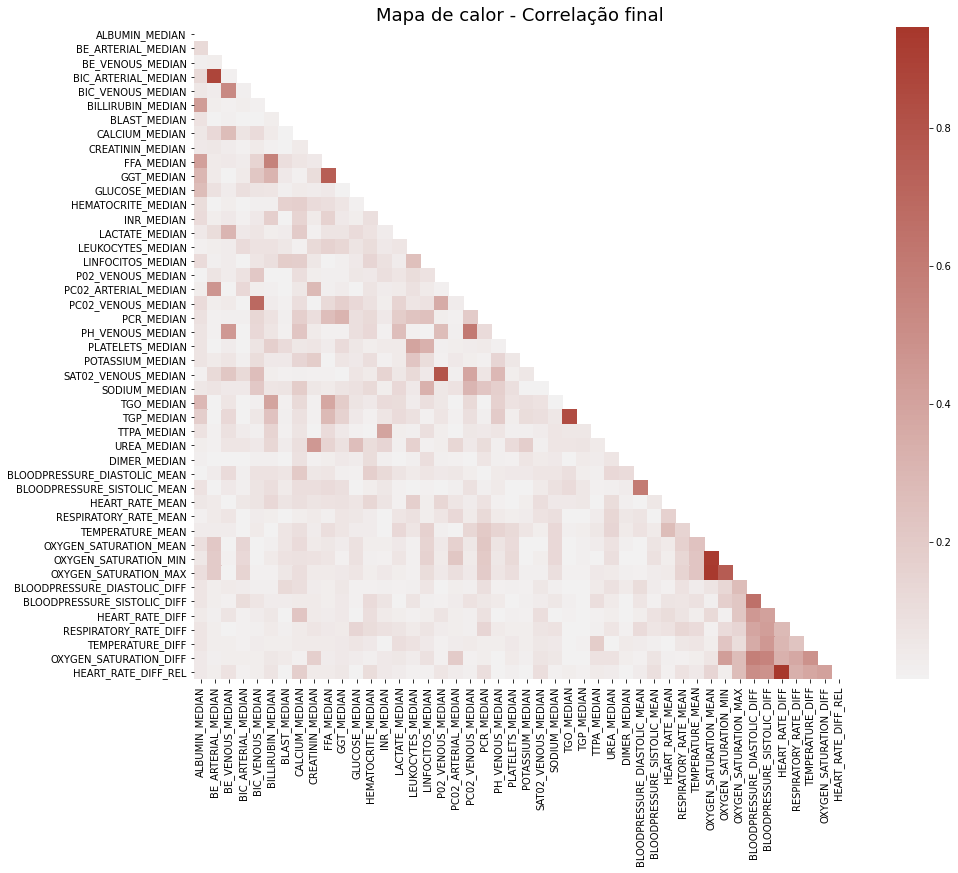

In [60]:
corr_plot(m_corr = final_corr, title = "Mapa de calor - Correlação final")

Agora temos um bom resultado, com uma quantidade razoável de colunas com baixa correlação entre elas.

In [61]:
df_clean = pd.concat([cat_features, cont_features, out], axis = 1)

In [62]:
df_clean

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,OXYGEN_SATURATION_MIN,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0,0,0,0,1,0,0,0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,-0.932246,1.000000,-0.835844,-0.914938,-0.704142,-0.77931,-0.754601,-0.875236,0.363636,-0.540721,-0.518519,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.898990,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,-0.959849,1.000000,-0.382773,-0.908714,-0.704142,-0.77931,-0.754601,-0.939887,0.363636,-0.399199,-0.703704,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,0.959596,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
2,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0,1,0,0,0,0,0,-0.263158,-1.0,-1.000000,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.959849,-0.828421,-0.729239,-0.836100,-0.633136,-0.77931,-0.779141,-0.503592,0.363636,-0.564753,-0.777778,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.878788,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,-0.959849,1.000000,-0.702202,-0.641079,-0.704142,-0.77931,-0.754601,-0.990926,0.363636,-0.457944,-0.592593,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.939394,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
4,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.891012,-0.742004,-0.958528,-0.891993,0.291405,-0.959849,1.000000,-0.706450,-0.340249,-0.704142,-0.77931,-0.754601,-0.997732,0.363636,-0.292390,-0.666667,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,0.919192,0.842105,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2

In [63]:
df_final.to_csv("data_pre_processing.csv", index = False)

df_clean.to_csv("data_clean.csv", index = False)

https://towardsdatascience.com/how-to-use-pairwise-correlation-for-robust-feature-selection-20a60ef7d10

https://www.kaggle.com/bbloggsbott/feature-selection-correlation-and-p-value